<center>
<h1>Objective: Estimation of individual medical insurance expenses based on factors such as age, BMI, smoking status, and other health-related variables.
</center>

# Data Import and Basic Analysis

In [1]:
# Importing necessary dependencies
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

<b>Features overview:</b>
1. age: Age of primary policyholder
2. sex: Gender of the insurance policymaker (female or male)
3. bmi: Body Mass Index, a measure that uses the ratio of weight to height (kg/m2) to categorize body weight, ideally ranging from 18.5 to 24.9
4. children: Number of dependents covered by the health insurance
5. smoker: Indicates if the person smokes
6. region: The geographical area in the U.S. where the policymaker resides (northeast, southeast, southwest, northwest)
7. charges: Medical expenses billed to the insurance for the individual

In [2]:
# Reading the data
df = pd.read_csv('data_insurance.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df.drop(['sex', 'smoker', 'region'], axis=1).corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


Note: Excluding the categorical features for now, will include them later

In [8]:
# Checking for missing values
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Observation: No missing values found

In [9]:
# Checking for duplicates
df.duplicated().sum()

np.int64(1)

Observation: 1 duplicate entry found

In [10]:
# Printing the duplicated entries
duplicates = df[df.duplicated(keep = False)]
print(duplicates)

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


Observation: 1 duplicate entry found

In [11]:
# Removing the duplicate entries
df.drop_duplicates(inplace = True)

In [12]:
df.shape

(1337, 7)

# Univariate Analysis and Feature Engineering

In [13]:
# Splitting the features into numerical and categorical features
numerical_features = [features for features in df.columns if df[features].dtypes != 'O']
print('Number of numerical features: ', len(numerical_features))
print(numerical_features)

Number of numerical features:  4
['age', 'bmi', 'children', 'charges']


In [14]:
categorical_features = [features for features in df.columns if df[features].dtypes == 'O']
print('Number of categorical features: ', len(categorical_features))
print(categorical_features)

Number of categorical features:  3
['sex', 'smoker', 'region']


In [15]:
# Creating a new df for feature engineering
df1 =  df.copy()

In [16]:
df1.shape

(1337, 7)

Feature 0: Charges

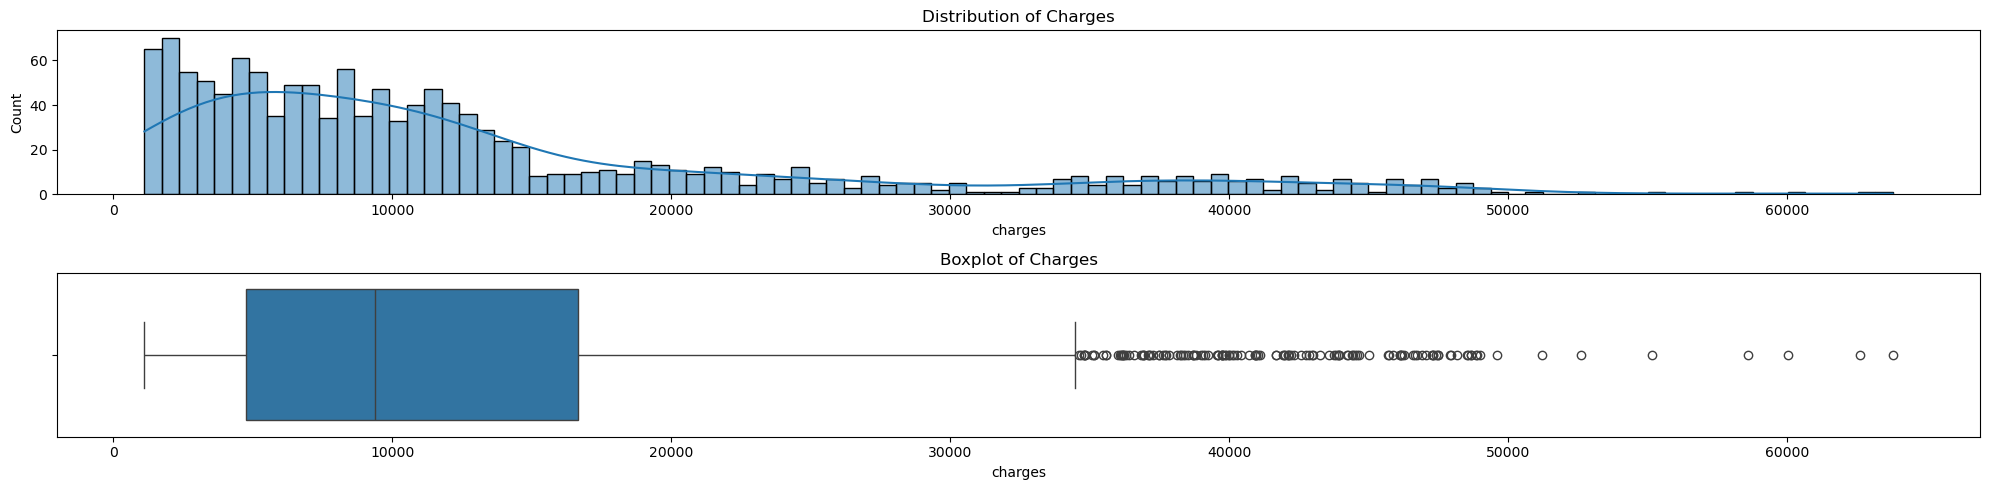

In [17]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.histplot(data = df, x = 'charges', bins = 100, kde = True)
plt.title('Distribution of Charges')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df, x ='charges')
plt.title('Boxplot of Charges')

plt.tight_layout()
plt.show()

Observations: 
1. The distribution is positively skewed (right-skewed). Most of the datapoints are concentrated on the right side with a tail extending to the right. This indicates that while many individuals have lower charges, a few have significant higher charges.
2. There are significant outliers in the feature, will require data transformation.
3. The distribution exhibits positive kurtosis, with higher peak and flatter tails compared to a normal distribution.

Doing feature engineering in charges

In [18]:
# Finding the number of outliers in the charges feature
Q1 = df1['charges'].quantile(0.25)
Q3 = df1['charges'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding out the number of outliers
outliers_charges = df1[(df1['charges'] < lower_bound) | (df1['charges'] > upper_bound)]
print('Number of outliers in the Charges feature: ', len(outliers_charges))

Number of outliers in the Charges feature:  139


Observation: Since the percentage of outliers in the target feature is more than 10%, removing the outliers would lead to a loss of information. Here, capping the outliers make a lot more sense.

In [19]:
# # # Capping the outliers in the charges feature
# df1['charges'] = np.where(df1['charges'] > upper_bound, upper_bound, df1['charges'])
# df1['charges'] = np.where(df1['charges'] < lower_bound, lower_bound, df1['charges'])

# print('Number of outliers after capping: ', len(df1[(df1['charges'] > upper_bound) | (df1['charges'] < lower_bound)]))


In [20]:
# Capping the outliers in the charges features by applying to the 99th percentile
upper_bound = df1['charges'].quantile(0.99)
df1['charges'] = np.where(df1['charges'] > upper_bound, upper_bound, df1['charges'])

In [21]:
df1.shape

(1337, 7)

Since the charges feature is right skewed, appliying log transformation

In [22]:
# Applying the boxcox transformation to the charges feature
df1['charges'], _ = boxcox(df1['charges'])
# Applying the log transformation to the charges feature
# df1['charges'] = np.log(df1['charges'])

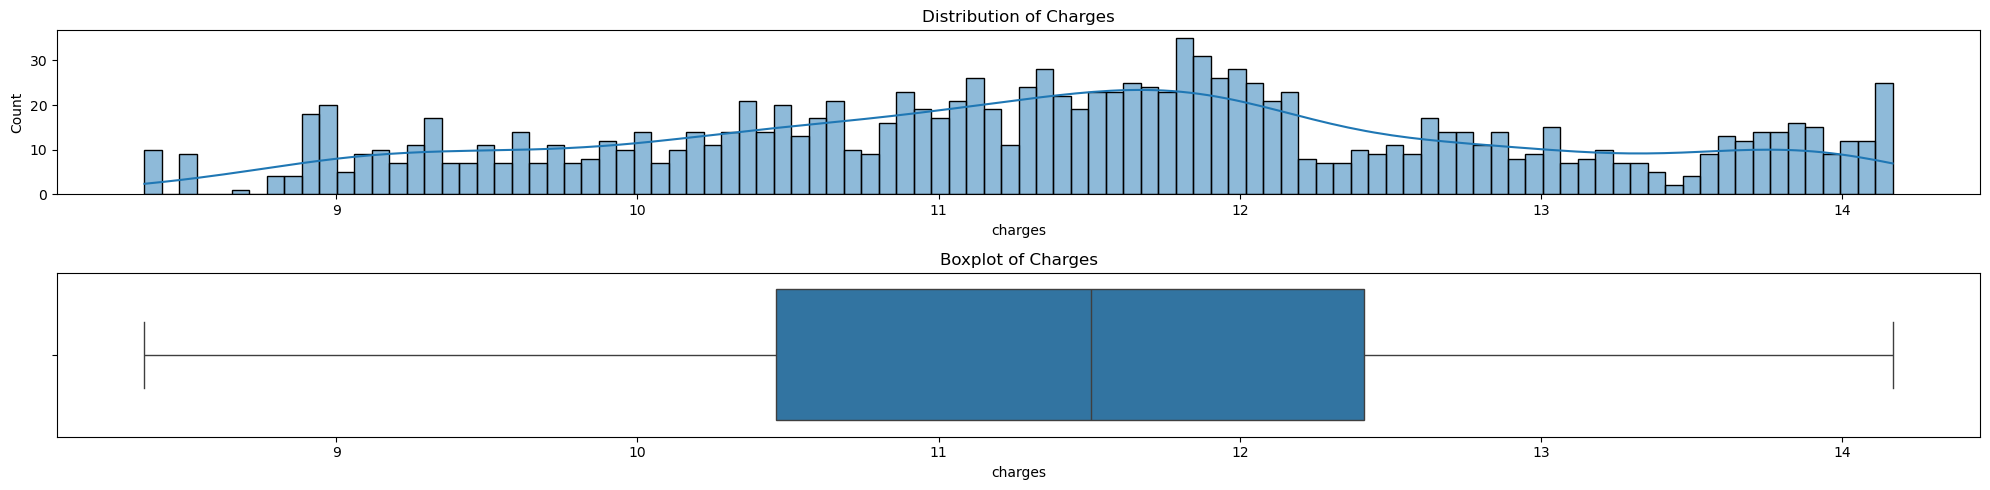

In [23]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.histplot(data = df1, x = 'charges', bins = 100, kde = True)
plt.title('Distribution of Charges')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df1, x ='charges')
plt.title('Boxplot of Charges')

plt.tight_layout()
plt.show()

Feature 1: Age

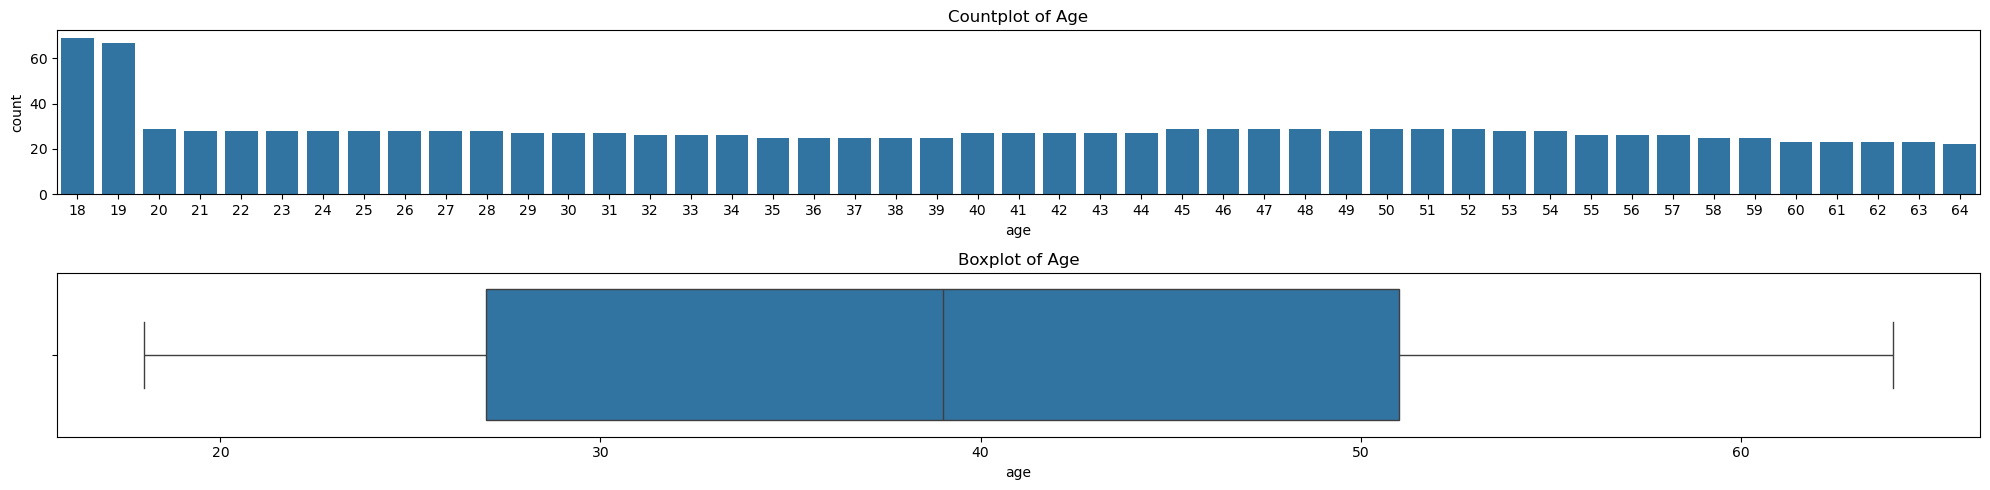

In [24]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.countplot(data = df, x = 'age')
plt.title('Countplot of Age')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df, x ='age')
plt.title('Boxplot of Age')

plt.tight_layout()
plt.show()

Observations:
1. Most of the people are of the age 18 and 19

Feature 2: BMI

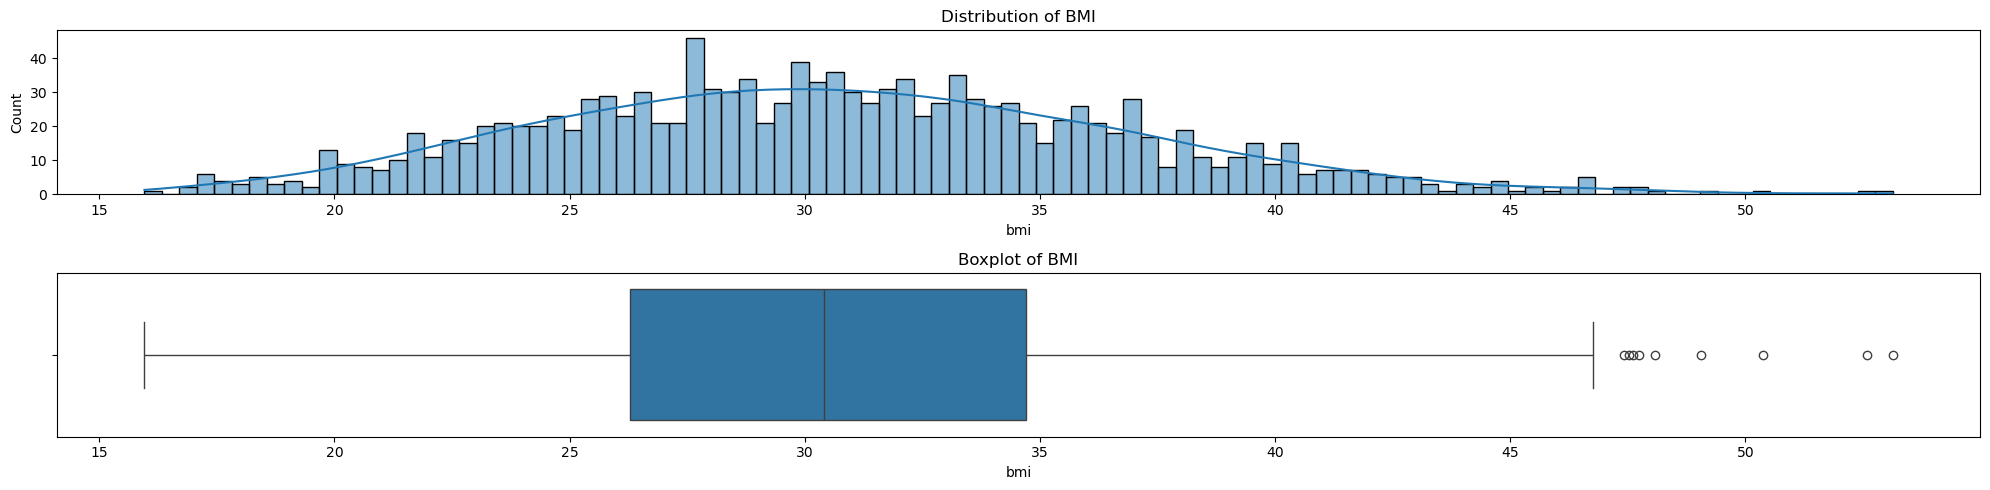

In [25]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.histplot(data = df, x = 'bmi', bins = 100, kde = True)
plt.title('Distribution of BMI')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df, x ='bmi')
plt.title('Boxplot of BMI')

plt.tight_layout()
plt.show()

Observations: 
1. Follows distorted normal distribution
2. Have outliers

Handling outliers in bmi

In [26]:
# Finding the number of outliers in the bmi feature
Q1 = df1['bmi'].quantile(0.25)
Q3 = df1['bmi'].quantile(0.75)
IQR = Q3 - Q1
outliers_bmi = df1[(df1['bmi'] < (Q1 - 1.5 * IQR)) | (df1['bmi'] > (Q3 + 1.5 * IQR))]
print('Number of outliers in the BMI feature: ', outliers_bmi.shape[0])

Number of outliers in the BMI feature:  9


Since there are over 1300 entries, hence removing 9 datapoints won't make much difference.

In [27]:
# Removing the outliers in the bmi feature
df1 = df1[(df1['bmi'] >= (Q1 - 1.5 * IQR)) & (df1['bmi'] <= (Q3 + 1.5 * IQR))]
print('Number of outliers removed: ', outliers_bmi.shape[0])

Number of outliers removed:  9


In [28]:
df1.shape

(1328, 7)

In [29]:
# Now, transforming the bmi feature to a normal distribution
df1['bmi'], _ = boxcox(df1['bmi'])

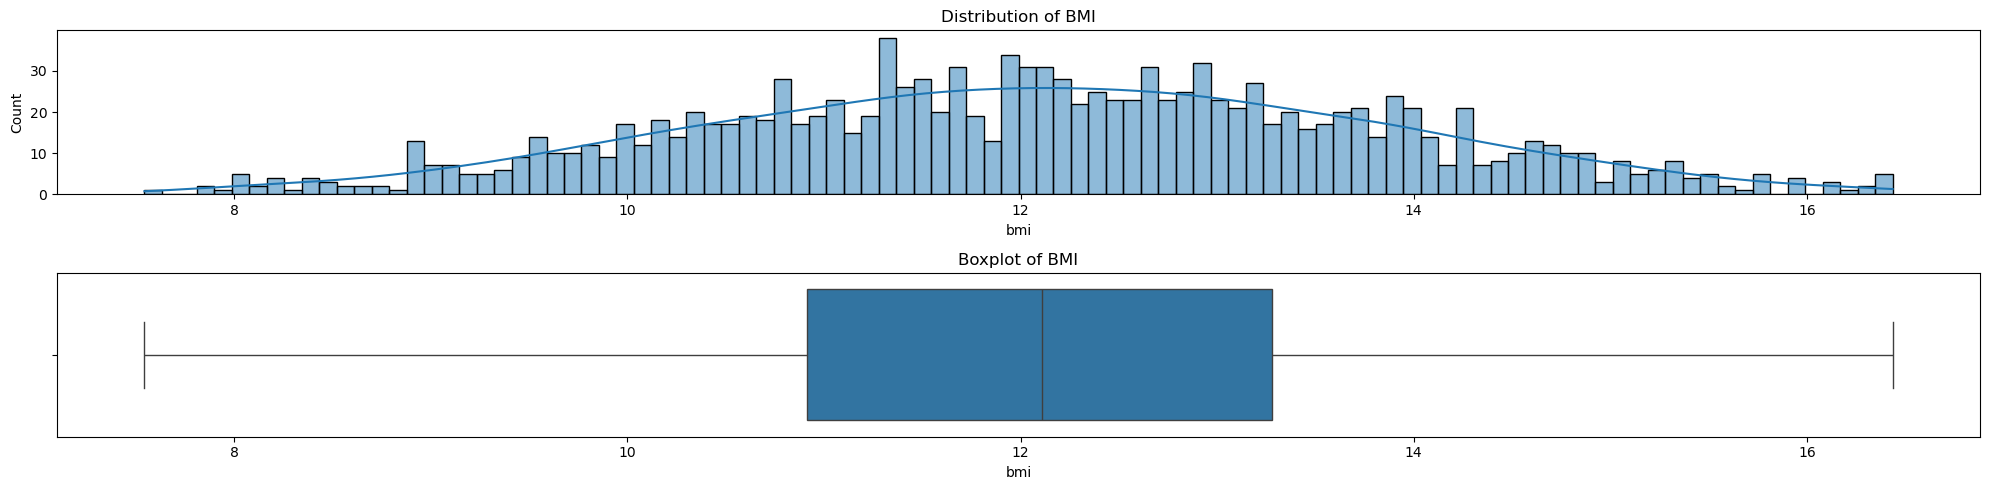

In [30]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.histplot(data = df1, x = 'bmi', bins = 100, kde = True)
plt.title('Distribution of BMI')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df1, x ='bmi')
plt.title('Boxplot of BMI')

plt.tight_layout()
plt.show()

Feature 3: Children

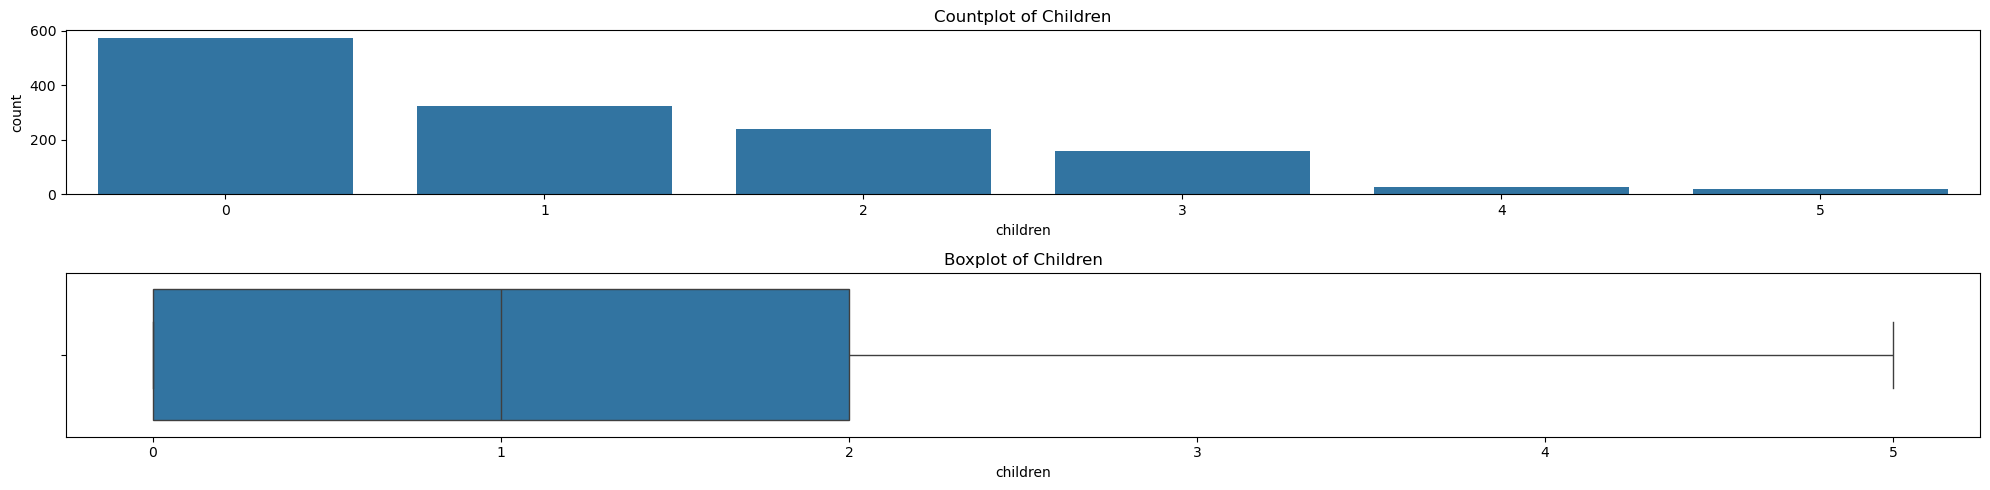

In [31]:
plt.figure(figsize = (20,5))

# First subplot
plt.subplot(2,1,1)
sns.countplot(data = df, x = 'children')
plt.title('Countplot of Children')

# Second subplot
plt.subplot(2,1,2)
sns.boxplot(data = df, x ='children')
plt.title('Boxplot of Children')

plt.tight_layout()
plt.show()

Observations:
1. Most of the people don't have children which makes sense as most of the people are of age 18 and 19

Feature 4: Sex

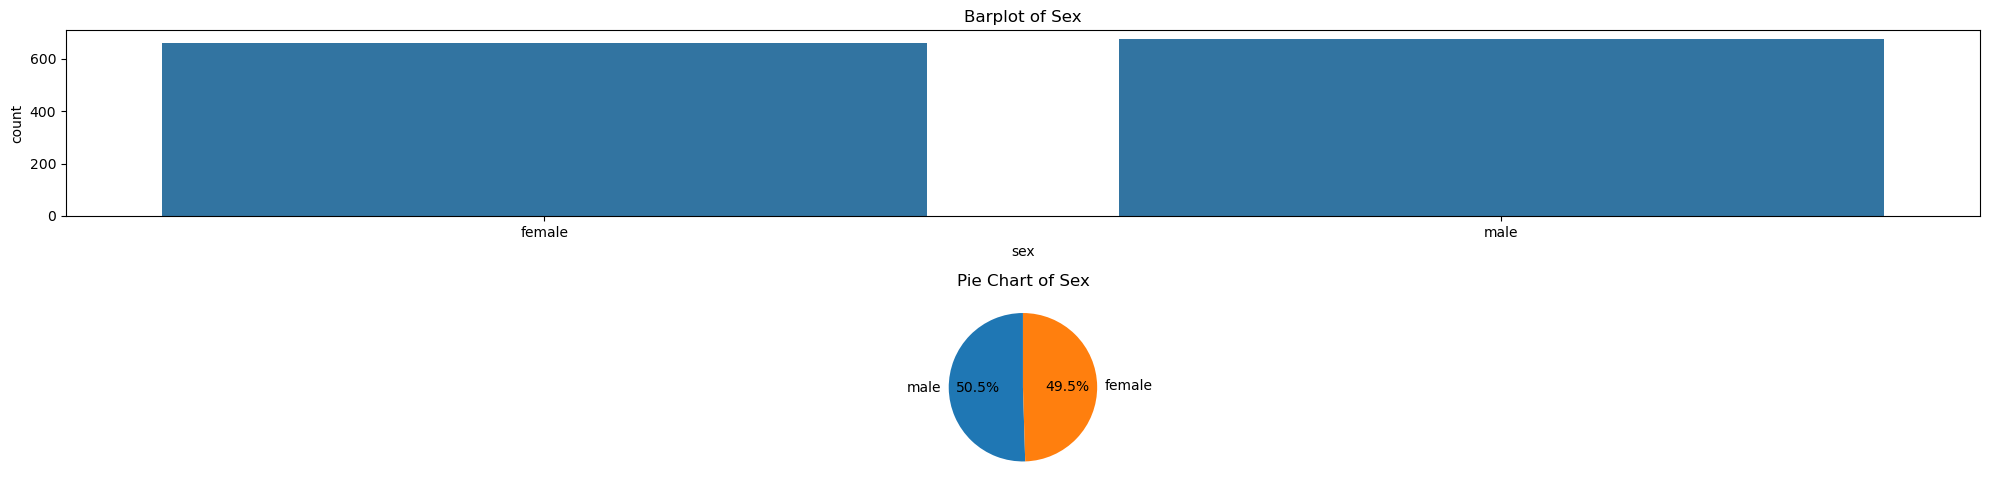

In [32]:
plt.figure(figsize = (20, 5))

# First subplot
plt.subplot(2, 1, 1)
sns.countplot(data = df, x = 'sex')
plt.title('Barplot of Sex')

# Second subplot
feature = df['sex'].value_counts()
plt.subplot(2, 1, 2)
plt.pie(feature, labels = feature.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Pie Chart of Sex')

plt.tight_layout()
plt.show()

Observations:
1. There is almost equal distribution between males and females

Feature 5: Smoker

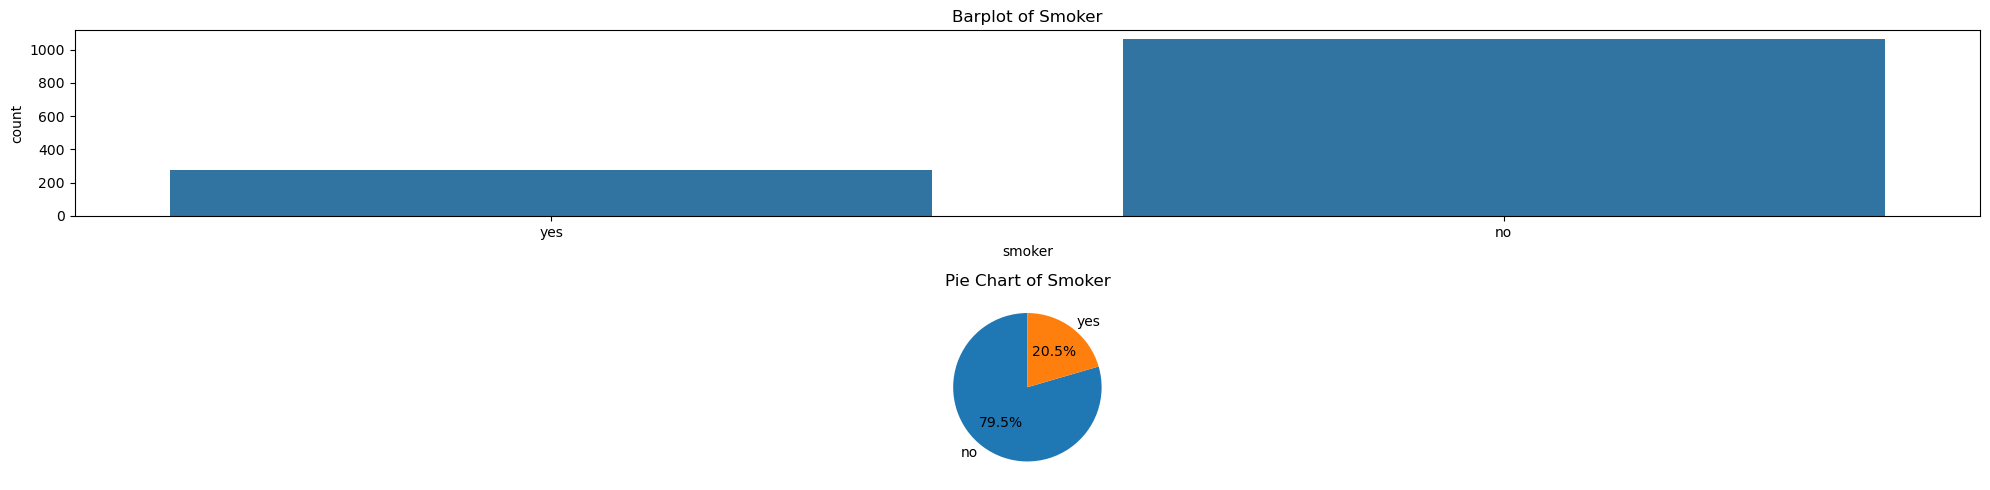

In [33]:
plt.figure(figsize = (20, 5))

# First subplot
plt.subplot(2, 1, 1)
sns.countplot(data = df, x = 'smoker')
plt.title('Barplot of Smoker')

# Second subplot
feature = df['smoker'].value_counts()
plt.subplot(2, 1, 2)
plt.pie(feature, labels = feature.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Pie Chart of Smoker')

plt.tight_layout()
plt.show()

Observations:
1. There is clear domination of non-smokers in the dataset.

Feature 6: Region

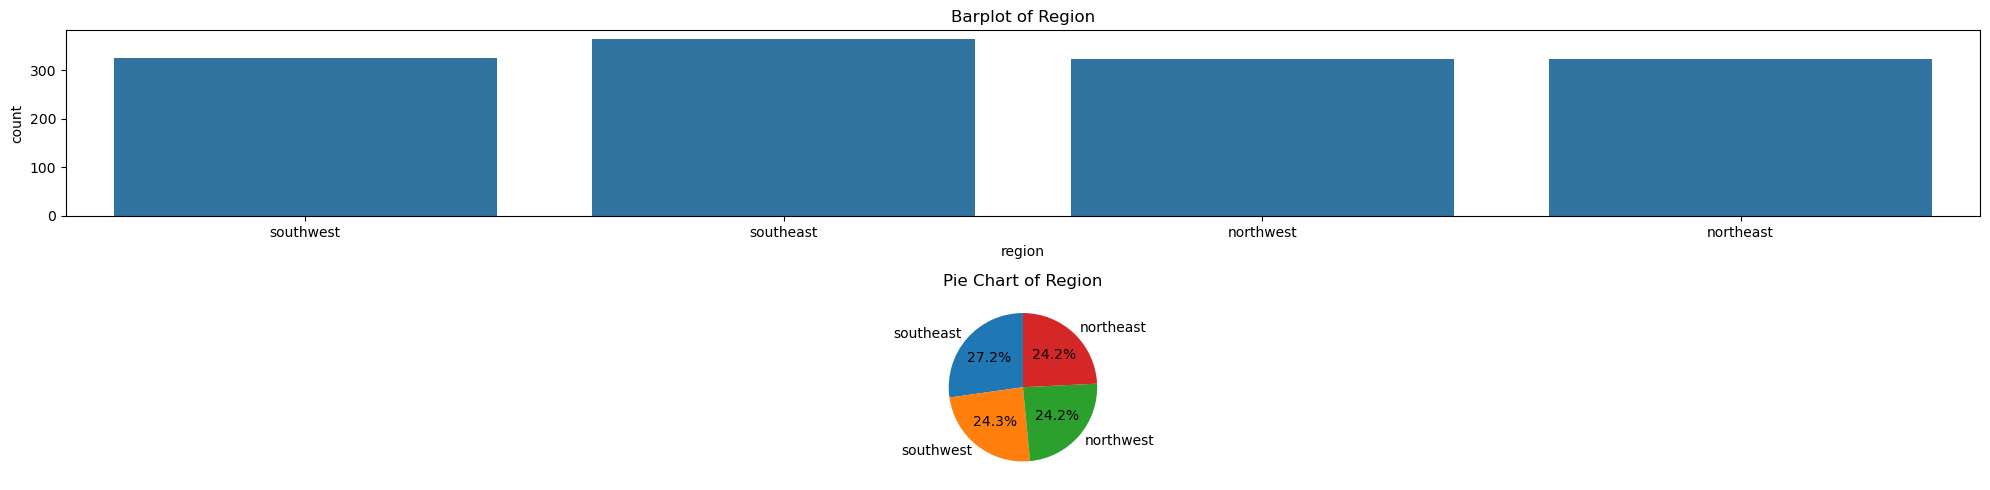

In [34]:
plt.figure(figsize = (20, 5))

# First subplot
plt.subplot(2, 1, 1)
sns.countplot(data = df, x = 'region')
plt.title('Barplot of Region')

# Second subplot
feature = df['region'].value_counts()
plt.subplot(2, 1, 2)
plt.pie(feature, labels = feature.index, autopct = '%1.1f%%', startangle = 90)
plt.title('Pie Chart of Region')

plt.tight_layout()
plt.show()

Observations:
1. The dataset is almost equally distributed among the four categories.

<h3>Encoding the categorical features

In [35]:
##Converting objects labels into categorical
df1[['sex', 'smoker', 'region']] = df1[['sex', 'smoker', 'region']].astype('category')
df1.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [36]:
# Encoding the categorical features using the label encoder
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

label.fit(df1.sex.drop_duplicates())
df1.sex = label.transform(df1.sex)
label.fit(df1.smoker.drop_duplicates())
df1.smoker = label.transform(df1.smoker)
label.fit(df1.region.drop_duplicates())
df1.region = label.transform(df1.region)
df1.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [37]:
# Encoding the sex and smoker feature using one-hot encoding
#df1 = pd.get_dummies(df1, columns = ['sex', 'smoker'], drop_first = True)

In [38]:
df1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,11.413524,0,1,3,12.432353
1,18,1,13.083029,1,0,2,8.974062
2,28,1,12.870483,3,0,2,10.364103
3,33,1,9.824606,0,0,1,12.857695
4,32,1,11.700617,0,0,1,10.154115


In [39]:
# Encoding the region feature using one-hot encoding
#df1 = pd.get_dummies(df1, columns = ['region'], drop_first = True)
df1.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,11.413524,0,1,3,12.432353
1,18,1,13.083029,1,0,2,8.974062
2,28,1,12.870483,3,0,2,10.364103
3,33,1,9.824606,0,0,1,12.857695
4,32,1,11.700617,0,0,1,10.154115


# Multivariate Analysis

<h3>Pairplot

<Figure size 4000x2000 with 0 Axes>

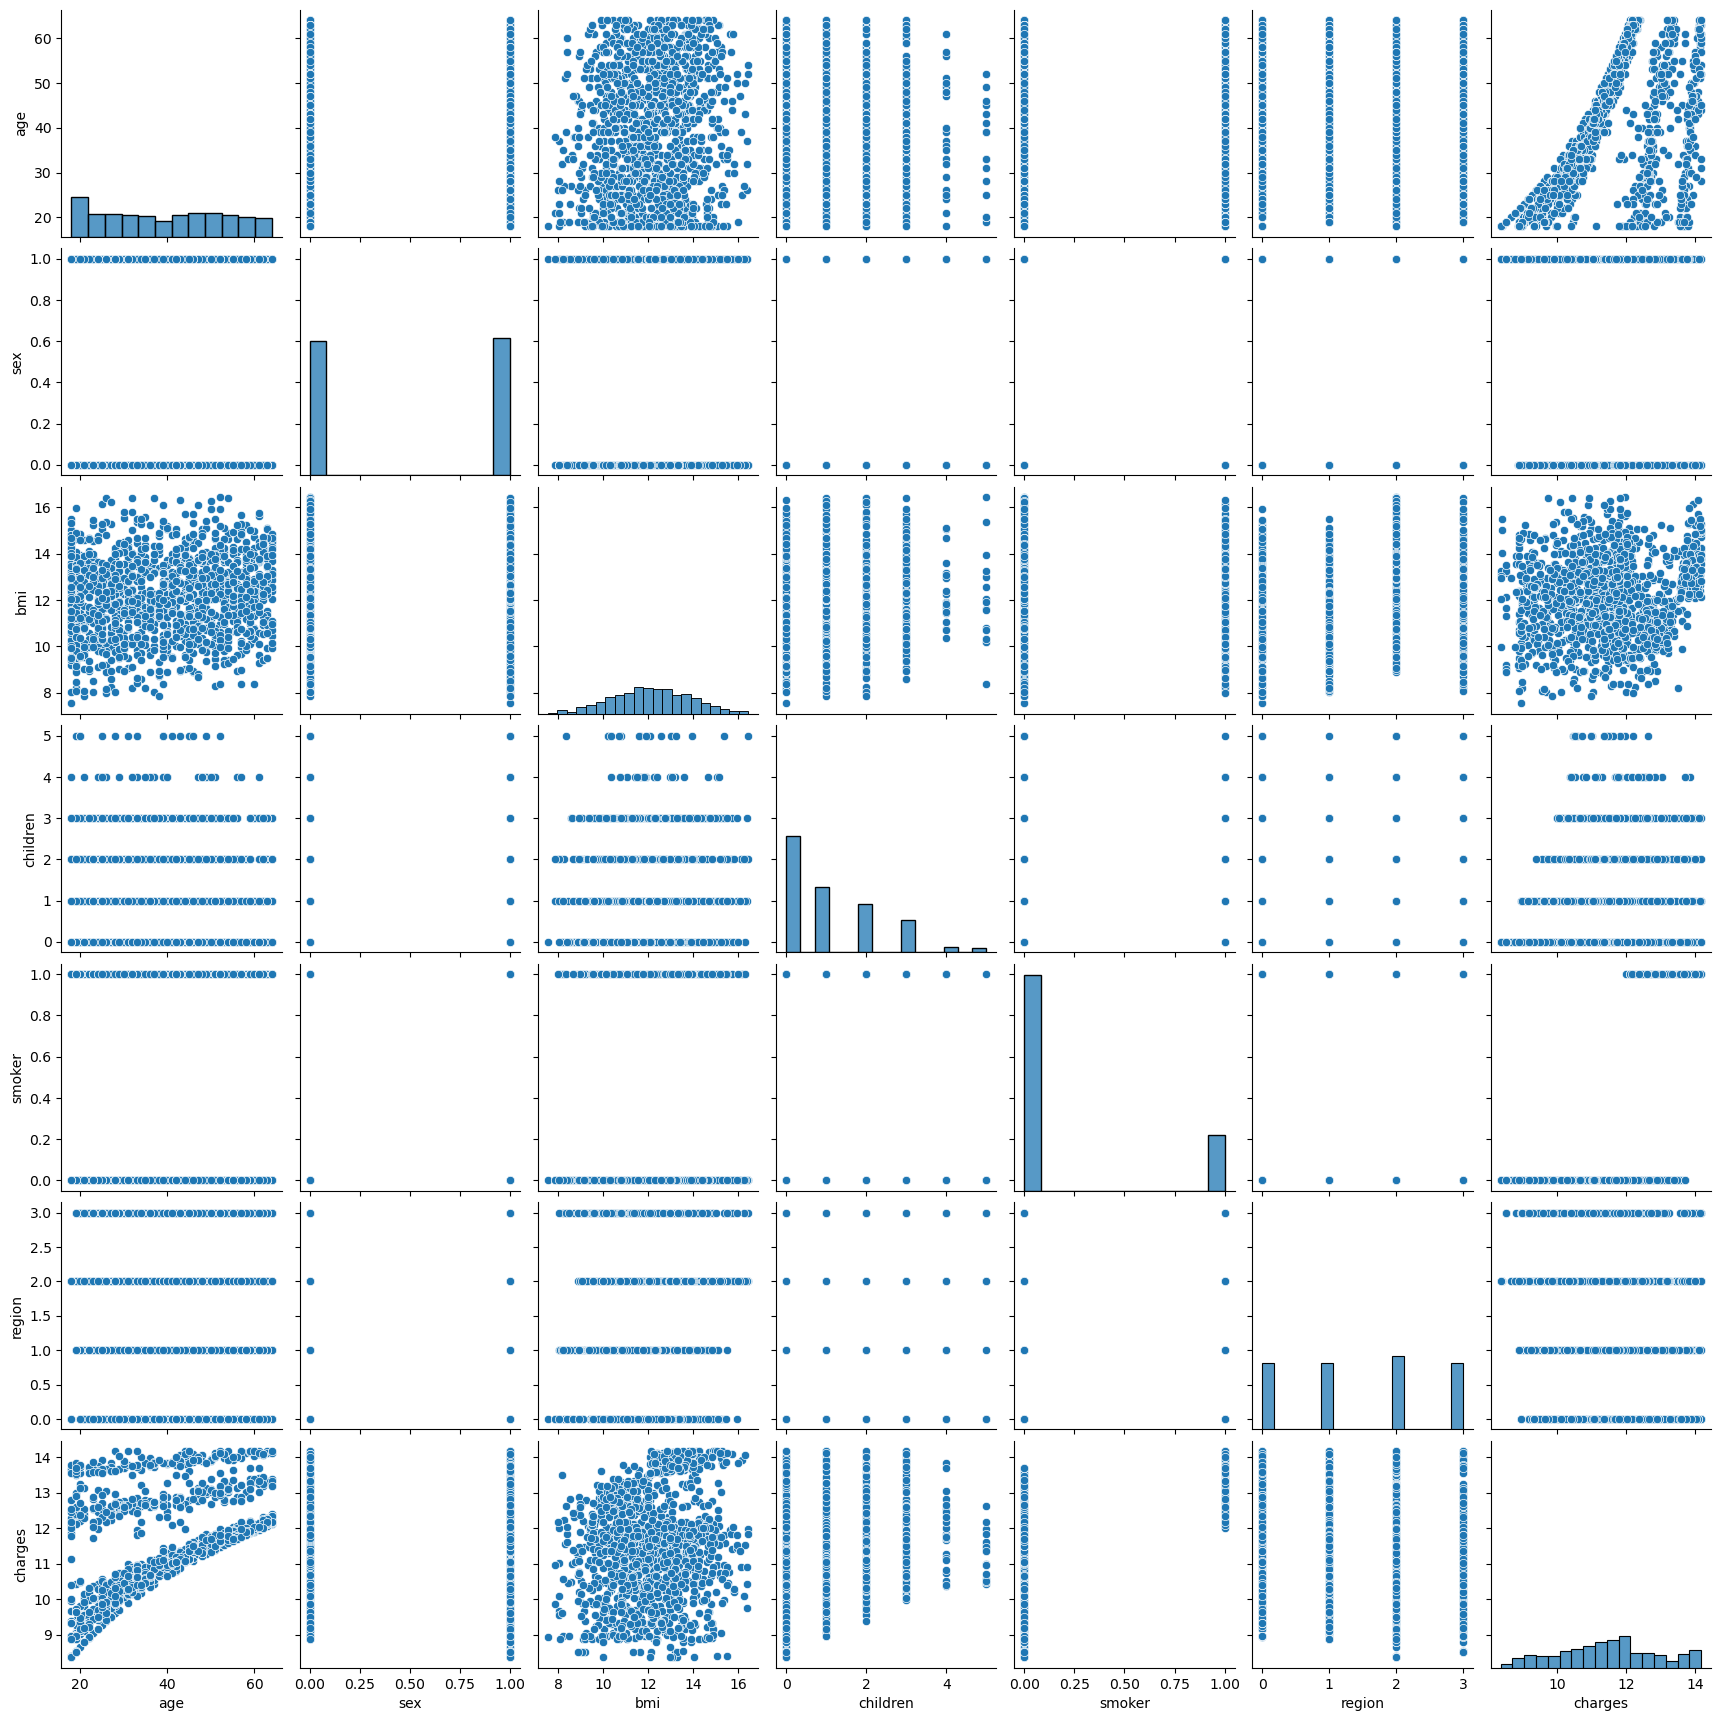

In [40]:
plt.figure(figsize = (40, 20))
sns.pairplot(df1)
plt.show()

<h3> Correlation Map

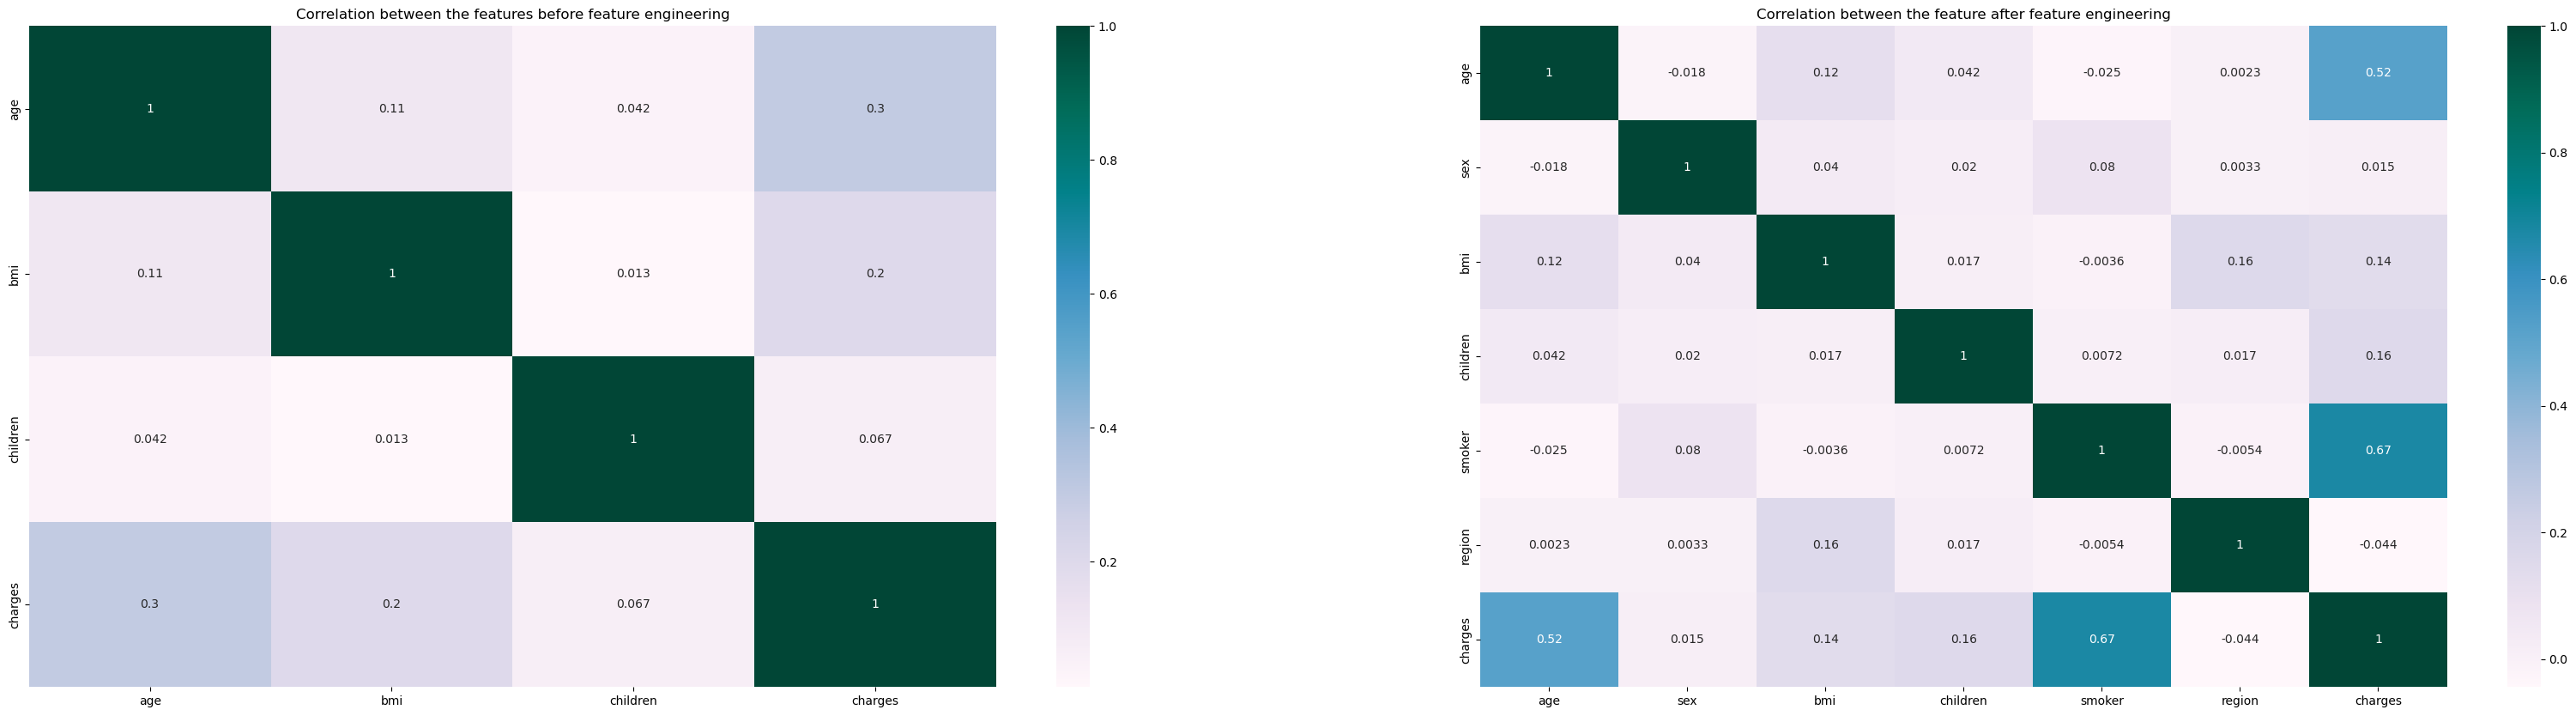

In [41]:
# Checking the correlation between the features before and after doing the feature engineering and transformation
plt.figure(figsize = (40, 10))

# Subplot 1
plt.subplot(1, 2, 1)
sns.heatmap(df.drop(['smoker', 'region', 'sex'], axis = 1).corr(), annot = True, cmap = 'PuBuGn')
plt.title('Correlation between the features before feature engineering')

# Subplot 2
plt.subplot(1, 2, 2)
sns.heatmap(df1.corr(), annot = True, cmap = 'PuBuGn')
plt.title('Correlation between the feature after feature engineering')

plt.show()

# Model Training

<h3>Dividing the data into dependent and independent features

In [42]:
# Splitting the data into features and target variable
# X = Independent features, y = Dependent feature
X = df1.drop('charges', axis = 1)
y = df1['charges']

<h3>Splitting the data

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

<h3>Scaling the data

In [44]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

Transforming both Training and Testing Data

In [45]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h3>Training the model

In [46]:
model = LinearRegression()

In [47]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [48]:
y_pred = model.predict(X_test_scaled)

Assessing the model's performance using MSE and R2 metrics

In [49]:
# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error: ', mse)

# Calculating the R-squared value
r_squared = model.score(X_test_scaled, y_test)
print('R-squared: ', r_squared)

Mean Squared Error:  0.40022426856799825
R-squared:  0.8044406788687021


<h3>Analyzing the model's coefficients

In [50]:
# Analyzing the model's coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns = ['Coefficient'])
print(coefficients)

          Coefficient
age          0.733300
sex         -0.032229
bmi          0.141497
children     0.179955
smoker       0.978596
region      -0.069144


<Figure size 2000x500 with 0 Axes>

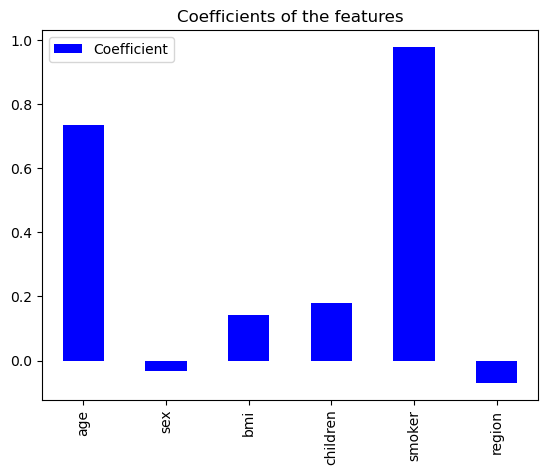

In [51]:
# Plotting the coefficients
plt.figure(figsize = (20,5))
coefficients.plot(kind = 'bar', color = 'blue')
plt.title('Coefficients of the features')
plt.show()

# Conclusion

<center> <b> Since the feature are scaled using the StandardScaler() before the application of the model, this means that higher the value of the coefficient higher the impact it has on the target feature. 
</><center>According to this, Feature 'smoker' and 'age' have the highest impact on the 'charges' of the medical expenses. 

# Model Enhancement (Optional)

Since most the enhancements are already done during the Univariate Analysis and Feature Engineering, one enhancement that can be done is by changing the dataset split size. 

In [52]:
# Test sizes to evaluate
test_sizes = [0.1, 0.15, 0.2, 0.3]
mse_list = []
r_squared_list = []

In [53]:
for test_size in test_sizes:
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=22)
    
    # Scaling the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Training the model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Assessing the model's performance
    mse = mean_squared_error(y_test, y_pred)
    r_squared = model.score(X_test_scaled, y_test)
    
    mse_list.append(mse)
    r_squared_list.append(r_squared)
    
    print(f"Test Size: {test_size}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r_squared}")
    print()

Test Size: 0.1
Mean Squared Error: 0.44189453754856356
R-squared: 0.7640666543717072

Test Size: 0.15
Mean Squared Error: 0.44238455261429677
R-squared: 0.7726892432023559

Test Size: 0.2
Mean Squared Error: 0.40022426856799825
R-squared: 0.8044406788687021

Test Size: 0.3
Mean Squared Error: 0.42365118934321017
R-squared: 0.7931700138307475



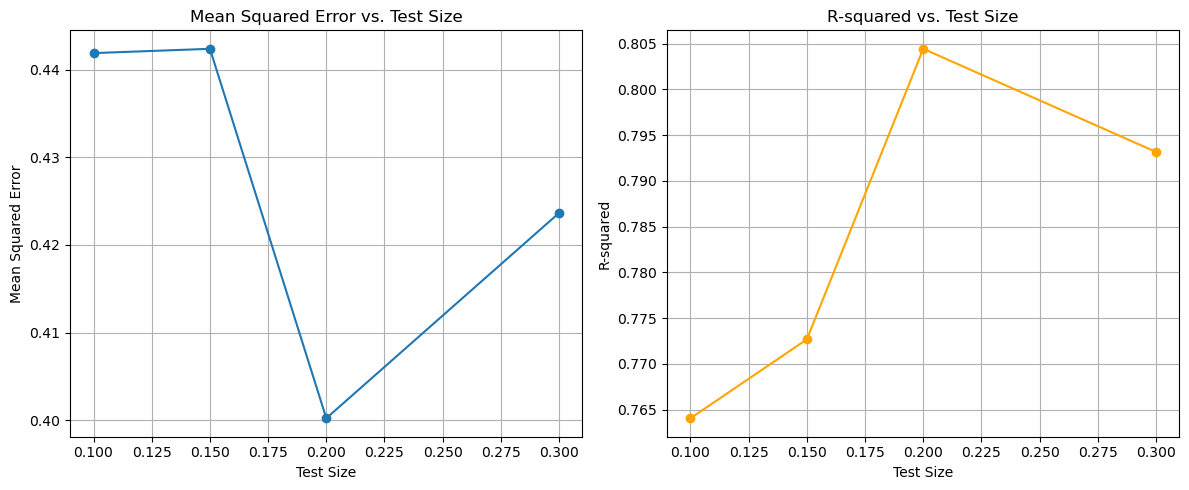

In [54]:
# Plotting the results
plt.figure(figsize=(12, 5))

# Plot for MSE
plt.subplot(1, 2, 1)
plt.plot(test_sizes, mse_list, marker='o')
plt.title('Mean Squared Error vs. Test Size')
plt.xlabel('Test Size')
plt.ylabel('Mean Squared Error')
plt.grid(True)

# Plot for R-squared
plt.subplot(1, 2, 2)
plt.plot(test_sizes, r_squared_list, marker='o', color='orange')
plt.title('R-squared vs. Test Size')
plt.xlabel('Test Size')
plt.ylabel('R-squared')
plt.grid(True)

plt.tight_layout()
plt.show()

Observation: As seen from the graph, increasing the test size does have a good impact on the model's performance but only upto a certain level, after a certain threshold, the there is just isn't enough data for the model to learn and refine the weights appropriately. However, this values varies with data and the complexity of the model.

<h4>Other Refinements

In [55]:
# Polynomial Feature Engineering
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

In [56]:
# Cross-Validation
model = LinearRegression()
cv_scores = cross_val_score(model, X_poly, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores)}')

Cross-Validation Scores: [0.88007607 0.73941725 0.86988947 0.82146348 0.79954758]
Mean CV Score: 0.8220787695285372


In [57]:
# Hyperparameter Tuning with Grid Search
param_grid = {'alpha': [0.1, 1, 10]}
grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'alpha': 1}


In [58]:
# Regularization
ridge_model = Ridge(alpha=grid_search.best_params_['alpha'])
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [59]:
# Evaluate Model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge Model Mean Squared Error: {mse_ridge}')

Ridge Model Mean Squared Error: 0.42373634747724404


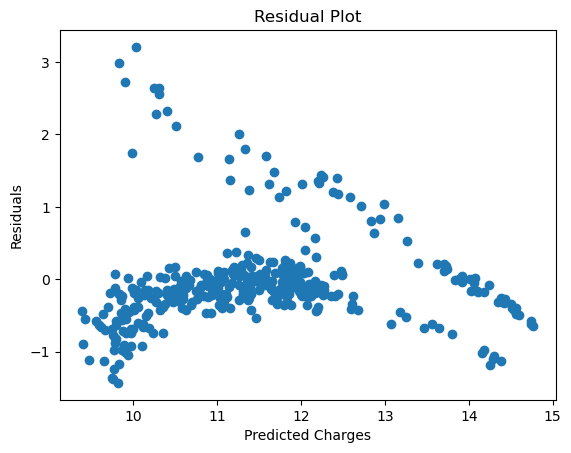

In [60]:
# Plot Residuals
residuals = y_test - y_pred_ridge
plt.scatter(y_pred_ridge, residuals)
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()